In [29]:
# Useful libraries
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import TensorDataset
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

from torch.cuda import is_available

import librosa

In [30]:
# Modified version of AlexNet from lecture to support 432x228 RGB images
# https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.name = "AlexNet"
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(6144, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, 10)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [31]:
"""path = 'dataset/'

train_set_features = torchvision.datasets.DatasetFolder(path + 'TrainFeatures', loader=torch.load, extensions=('.tensor'))
valid_set_features = torchvision.datasets.DatasetFolder(path + 'ValidFeatures', loader=torch.load, extensions=('.tensor'))
test_set_features = torchvision.datasets.DatasetFolder(path + 'TestFeatures', loader=torch.load, extensions=('.tensor'))
print("train set size: ", len(train_set_features))
print("validation set size: ", len(valid_set_features))
print("test set size: ", len(test_set_features))"""

# credit: https://stackoverflow.com/questions/60173417/pytorch-default-dataloader-gets-stuck-for-large-image-classification-training-se

import os
import pathlib

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, folder: str, klass: int, extension: str = "png", transform = None):
        self._data = pathlib.Path(root) / folder
        self.klass = klass
        self.extension = extension
        self.transform = transform
        # Only calculate once how many files are in this folder
        # Could be passed as argument if you precalculate it somehow
        # e.g. ls | wc -l on Linux
        self._length = sum(1 for entry in os.listdir(self._data))

    def __len__(self):
        # No need to recalculate this value every time
        return self._length

    def __getitem__(self, index):
        # images always follow [0, n-1], so you access them directly
        return self.transform(Image.open(self._data / "{}.{}".format(str(index), self.extension)).convert('RGB')), self.klass

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

impath = "../IMData"
dataset = (
    ImageDataset(impath, "Arabic", 0, "png", transform)
    + ImageDataset(impath, "English", 1, "png", transform)
    + ImageDataset(impath, "French", 2, "png", transform)
    + ImageDataset(impath, "Hindi", 3, "png", transform)
    + ImageDataset(impath, "Indonesian", 4, "png", transform)
    + ImageDataset(impath, "Japanese", 5, "png", transform)
    + ImageDataset(impath, "Mandarin-CN", 6, "png", transform)
    + ImageDataset(impath, "Portuguese", 7, "png", transform)
    + ImageDataset(impath, "Russian", 8, "png", transform)
    + ImageDataset(impath, "Spanish", 9, "png", transform)
)

In [32]:
def get_data_loader(dataset, batch_size):
    # Load training data
    trainset = dataset

    # Get the list of indices to sample from
    relevant_indices = list(range(len(trainset)))
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    split2 = int(len(relevant_indices) * 0.9)
    
    # Split into training, validation, and testing indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split], relevant_indices[split:split2], relevant_indices[split2:]
    print("Train: {}, val: {}, test: {}".format(len(relevant_train_indices), len(relevant_val_indices), len(relevant_test_indices)))
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=0, sampler=train_sampler,
                                               pin_memory=True)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                             num_workers=0, sampler=val_sampler,
                                             pin_memory=True)
    
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=0, sampler=test_sampler,
                                              pin_memory=True)
   
    return train_loader, val_loader, test_loader

In [33]:
# Same as lab 2
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# Same as lab 2 but with different code for calculating error
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()

        outputs = net(inputs)
        loss = criterion(outputs, labels.long())

        # In this function and train_net I need to use a different method to 
        # compute the error. The output of the net, when put through a sigmoid
        # (which the CrossEntropyLoss function does automatically), returns
        # a tensor with a number for each classification. The "prediction"
        # of the network is the index which corresponds to the highest number
        # In order to check the prediction against the label, I find the index
        # of the maximum element in each prediction tensor using max
        # then simply loop through the result checking them against the 
        # labels, adding up the number of times the model was incorrect

        iz, ix = nn.Sigmoid()(outputs).max(dim=1)
        corr = 0
        for indx in range(len(ix)):
            if ix[indx] != labels[indx]:
                corr += 1
        total_err += int(corr)
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

results_path = "Results/"
def train_net(dataset, net, batch_size=64, learning_rate=0.01, num_epochs=100):
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(dataset, batch_size)

    # Define the Loss function and optimizer

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            if i % 100 == 0:
                print("Epoch {}: done {} batches".format(epoch, i))
            inputs, labels = data
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # See comment in function evaluate() for more detail on below code
            # and how it computes the error
            iz, ix = nn.Sigmoid()(outputs).max(dim=1)
            corr = 0
            for indx in range(len(ix)):
                if ix[indx] != labels[indx]:
                    corr += 1

            total_train_err += int(corr)
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} | "+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
    print('Finished Training')

    # Write the train/test loss/err into CSV file for plotting later
    # epochs = np.arange(1, num_epochs + 1)
    model_path = get_model_name(net.name, batch_size, learning_rate, num_epochs)
    torch.save(net.state_dict(), results_path + model_path)
    np.savetxt(results_path + "{}_train_err.csv".format(model_path), train_err)
    np.savetxt(results_path + "{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt(results_path + "{}_val_err.csv".format(model_path), val_err)
    np.savetxt(results_path + "{}_val_loss.csv".format(model_path), val_loss)

In [36]:
def main():
    net = AlexNet()
    
    if torch.cuda.is_available():
        print("working on cuda")
        net.cuda()
    else:
        print("not working on cuda")
    train_net(dataset, net, batch_size=64, learning_rate=0.01, num_epochs=20)

if __name__ == '__main__':
    main()

<function is_available at 0x000001E413E14DC0>
not working on cuda
Train: 71103, val: 8888, test: 8888
Epoch 0: done 0 batches


KeyboardInterrupt: 

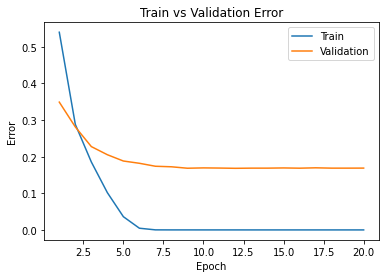

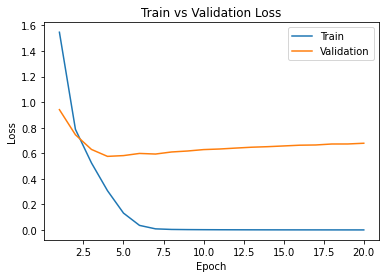

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

results_path = "/content/drive/MyDrive/Colab Notebooks/APS360/Project/Results/"
plot_training_curve(results_path + get_model_name("LeNet5", 256, 0.01, 20))